# Turkish Cyberbullying Detection - ML Model Training

Bu notebook'ta Turkish cyberbullying detection için 4 farklı makine öğrenmesi modeli eğitilecektir:
- Support Vector Machine (SVM)
- Logistic Regression
- Gradient Boosting
- Random Forest


## 1. Gerekli Kütüphanelerin Import Edilmesi


In [6]:
import pandas as pd
import numpy as np
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Kütüphaneler başarıyla yüklendi!")


✅ Kütüphaneler başarıyla yüklendi!


## 2. Veri Setinin Yüklenmesi


In [7]:
# Kaggle'da dosya yolu - kendi dataset adınıza göre güncelleyin
# Örnek: /kaggle/input/turkish-cyberbullying/nlpaug_turkish_augmented.csv
file_path = '/kaggle/input/turkish-cyberbullying-dataset/nlpaug_turkish_augmented.csv'

# Alternatif olarak direkt upload ettiyseniz:
# file_path = '../input/nlpaug_turkish_augmented.csv'

# CSV'yi doğru şekilde oku (virgül problemini çöz)
df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True)

print(f"📊 Orijinal veri seti boyutu: {df.shape}")

# Label sütununu temizle - sadece 0-4 arası kabul et
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# Geçersiz label'ları (NaN veya 0-4 dışındaki) filtrele
valid_labels = [0, 1, 2, 3, 4]
df = df[df['label'].isin(valid_labels)]

# NaN değerleri temizle
df = df.dropna(subset=['text', 'label'])

# Label'ı integer'a çevir
df['label'] = df['label'].astype(int)

# Boş text'leri temizle
df = df[df['text'].str.strip() != '']

# Index'i resetle
df = df.reset_index(drop=True)

print(f"✅ Temizlenmiş veri seti boyutu: {df.shape}")
print(f"\n📋 İlk 5 satır:")
print(df.head())
print(f"\n📈 Sınıf dağılımı:")
print(df['label'].value_counts().sort_index())


📊 Orijinal veri seti boyutu: (6257, 2)
✅ Temizlenmiş veri seti boyutu: (6221, 2)

📋 İlk 5 satır:
                                                text  label
0                 abla ben büyüyünce sen olucam 🔥 <3      0
1                 abla ben olucam büyüyünce sen 🔥 <3      0
2                  abla ben büyüyünce sen olucam 🔥 <      0
3  Abla böyle devam biz senin ve diğer tüm kadınl...      0
4  Abla böyle biz senin devam ve tüm diğer kadınl...      0

📈 Sınıf dağılımı:
label
0    2427
1    1071
2     428
3    1462
4     833
Name: count, dtype: int64


## 3. Veri Ön İşleme


In [8]:
def preprocess_text(text):
    """
    Turkish text preprocessing fonksiyonu
    """
    if pd.isna(text):
        return ""
    
    # Küçük harfe çevir
    text = str(text).lower()
    
    # Fazla boşlukları temizle
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Preprocessing uygula
df['processed_text'] = df['text'].apply(preprocess_text)

# Boş satırları temizle
df = df[df['processed_text'].str.len() > 0].reset_index(drop=True)

print(f"✅ Preprocessing tamamlandı!")
print(f"📊 Temizlenmiş veri boyutu: {df.shape}")
print(f"\n📝 Örnek işlenmiş text:")
print(df['processed_text'].iloc[0])


✅ Preprocessing tamamlandı!
📊 Temizlenmiş veri boyutu: (6221, 3)

📝 Örnek işlenmiş text:
abla ben büyüyünce sen olucam 🔥 <3


## 4. Feature Extraction (TF-IDF)


In [9]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams ve bigrams
    min_df=2,
    max_df=0.95
)

# Feature extraction
X = tfidf.fit_transform(df['processed_text'])
y = df['label']

print(f"✅ TF-IDF feature extraction tamamlandı!")
print(f"📊 Feature matrix boyutu: {X.shape}")
print(f"📊 Label boyutu: {y.shape}")

# TF-IDF vectorizer'ı kaydet
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("💾 TF-IDF vectorizer kaydedildi!")


✅ TF-IDF feature extraction tamamlandı!
📊 Feature matrix boyutu: (6221, 5000)
📊 Label boyutu: (6221,)
💾 TF-IDF vectorizer kaydedildi!


## 5. Train-Test Split


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Train-Test split tamamlandı!")
print(f"📊 Training set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"\n📈 Training set sınıf dağılımı:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\n📈 Test set sınıf dağılımı:")
print(pd.Series(y_test).value_counts().sort_index())


✅ Train-Test split tamamlandı!
📊 Training set: (4976, 5000)
📊 Test set: (1245, 5000)

📈 Training set sınıf dağılımı:
label
0    1941
1     857
2     342
3    1170
4     666
Name: count, dtype: int64

📈 Test set sınıf dağılımı:
label
0    486
1    214
2     86
3    292
4    167
Name: count, dtype: int64


## 6. Model Eğitimi ve Değerlendirme

### 6.1 Support Vector Machine (SVM)


In [11]:
print("🚀 SVM modeli eğitiliyor...\n")

# Model oluştur
svm_model = SVC(kernel='linear', C=1.0, random_state=42, verbose=1)

# Modeli eğit
svm_model.fit(X_train, y_train)

# Tahminler
y_pred_svm = svm_model.predict(X_test)

# Sınıf isimleri
class_names = [
    'No Harassment / Neutral',
    'Direct Insult / Profanity',
    'Sexist / Sexual Implication',
    'Sarcasm / Microaggression',
    'Appearance-based Criticism'
]

# Değerlendirme
print("\n" + "="*60)
print("SVM MODEL SONUÇLARI")
print("="*60)
print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# Modeli kaydet
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("💾 SVM modeli kaydedildi!\n")


🚀 SVM modeli eğitiliyor...

[LibSVM].
*.*
optimization finished, #iter = 2601
obj = -674.042750, rho = -0.649026
nSV = 1583, nBSV = 643
..*
optimization finished, #iter = 2849
obj = -302.411081, rho = -0.999450
nSV = 936, nBSV = 346
..*.*
optimization finished, #iter = 3018
obj = -888.558197, rho = -0.433578
nSV = 1929, nBSV = 845
..*
optimization finished, #iter = 2608
obj = -535.544816, rho = -0.965107
nSV = 1407, nBSV = 593
*.*
optimization finished, #iter = 1261
obj = -264.254443, rho = -0.646667
nSV = 742, nBSV = 219
.*.*
optimization finished, #iter = 2389
obj = -651.631282, rho = 0.197247
nSV = 1442, nBSV = 595
.*
optimization finished, #iter = 1719
obj = -425.256978, rho = -0.329020
nSV = 1013, nBSV = 368
.*
optimization finished, #iter = 1555
obj = -281.905177, rho = 0.686679
nSV = 920, nBSV = 216
*.*
optimization finished, #iter = 1251
obj = -233.590463, rho = 0.339201
nSV = 663, nBSV = 156
.*.*
optimization finished, #iter = 2162
obj = -474.645819, rho = -0.435391
nSV = 1198

### 6.2 Logistic Regression


In [12]:
print("🚀 Logistic Regression modeli eğitiliyor...\n")

# Model oluştur
lr_model = LogisticRegression(max_iter=1000, random_state=42, verbose=1, n_jobs=-1)

# Modeli eğit
lr_model.fit(X_train, y_train)

# Tahminler
y_pred_lr = lr_model.predict(X_test)

# Değerlendirme
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL SONUÇLARI")
print("="*60)
print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_lr, target_names=class_names))

# Modeli kaydet
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("💾 Logistic Regression modeli kaydedildi!\n")


🚀 Logistic Regression modeli eğitiliyor...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



LOGISTIC REGRESSION MODEL SONUÇLARI

📊 Accuracy: 0.7960

📋 Classification Report:

                             precision    recall  f1-score   support

    No Harassment / Neutral       0.72      0.96      0.82       486
  Direct Insult / Profanity       0.93      0.71      0.80       214
Sexist / Sexual Implication       0.94      0.40      0.56        86
  Sarcasm / Microaggression       0.82      0.78      0.80       292
 Appearance-based Criticism       0.94      0.66      0.78       167

                   accuracy                           0.80      1245
                  macro avg       0.87      0.70      0.75      1245
               weighted avg       0.82      0.80      0.79      1245

💾 Logistic Regression modeli kaydedildi!



### 6.3 Gradient Boosting


In [13]:
print("🚀 Gradient Boosting modeli eğitiliyor...\n")

# Model oluştur
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)

# Modeli eğit
gb_model.fit(X_train, y_train)

# Tahminler
y_pred_gb = gb_model.predict(X_test)

# Değerlendirme
print("\n" + "="*60)
print("GRADIENT BOOSTING MODEL SONUÇLARI")
print("="*60)
print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_gb, target_names=class_names))

# Modeli kaydet
with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)
print("💾 Gradient Boosting modeli kaydedildi!\n")


🚀 Gradient Boosting modeli eğitiliyor...

      Iter       Train Loss   Remaining Time 
         1           1.4259            9.93s
         2           1.4003            9.50s
         3           1.3773            9.41s
         4           1.3562            9.28s
         5           1.3378            9.20s
         6           1.3242            9.05s
         7           1.3100            8.98s
         8           1.2966            8.87s
         9           1.2842            8.78s
        10           1.2721            8.67s
        20           1.1701            7.63s
        30           1.1053            6.67s
        40           1.0451            5.68s
        50           0.9947            4.70s
        60           0.9528            3.75s
        70           0.9178            2.83s
        80           0.8829            1.88s
        90           0.8520            0.94s
       100           0.8249            0.00s

GRADIENT BOOSTING MODEL SONUÇLARI

📊 Accuracy: 0.6217

📋

### 6.4 Random Forest


In [14]:
print("🚀 Random Forest modeli eğitiliyor...\n")

# Model oluştur
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Modeli eğit
rf_model.fit(X_train, y_train)

# Tahminler
y_pred_rf = rf_model.predict(X_test)

# Değerlendirme
print("\n" + "="*60)
print("RANDOM FOREST MODEL SONUÇLARI")
print("="*60)
print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# Modeli kaydet
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("💾 Random Forest modeli kaydedildi!\n")


🚀 Random Forest modeli eğitiliyor...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s



RANDOM FOREST MODEL SONUÇLARI

📊 Accuracy: 0.4498

📋 Classification Report:

                             precision    recall  f1-score   support

    No Harassment / Neutral       0.42      1.00      0.59       486
  Direct Insult / Profanity       0.91      0.10      0.18       214
Sexist / Sexual Implication       0.00      0.00      0.00        86
  Sarcasm / Microaggression       0.97      0.11      0.20       292
 Appearance-based Criticism       1.00      0.13      0.22       167

                   accuracy                           0.45      1245
                  macro avg       0.66      0.27      0.24      1245
               weighted avg       0.68      0.45      0.34      1245

💾 Random Forest modeli kaydedildi!



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


## 7. Model Karşılaştırması



TÜM MODELLERİN KARŞILAŞTIRILMASI
              Model  Accuracy
                SVM  0.875502
Logistic Regression  0.795984
  Gradient Boosting  0.621687
      Random Forest  0.449799




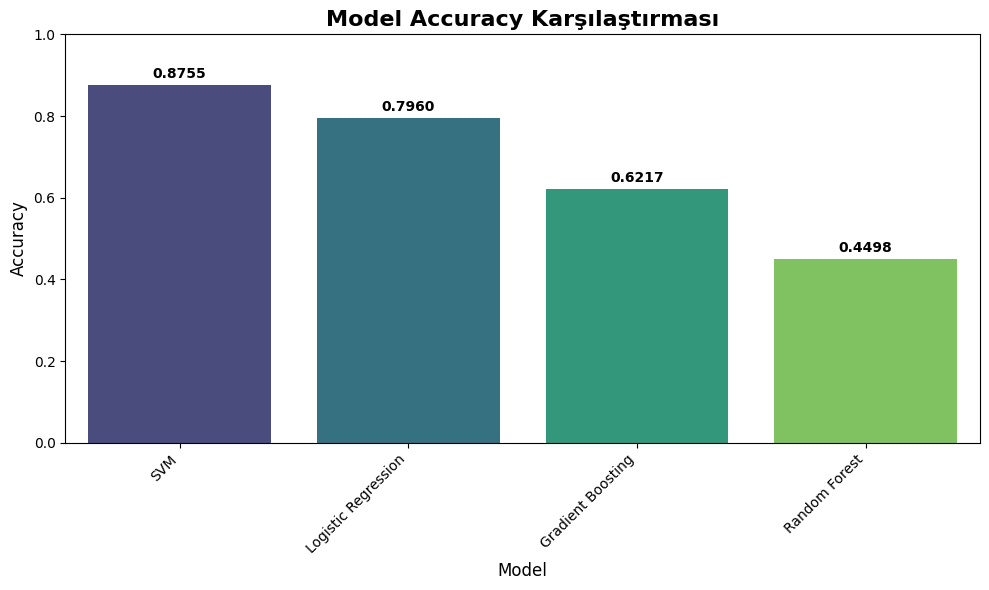


🏆 En iyi performans gösteren model: SVM (0.8755)


In [15]:
# Tüm modellerin accuracy skorlarını karşılaştır
results = {
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Gradient Boosting': accuracy_score(y_test, y_pred_gb),
    'Random Forest': accuracy_score(y_test, y_pred_rf)
}

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print("TÜM MODELLERİN KARŞILAŞTIRILMASI")
print("="*60)
print(results_df.to_string(index=False))
print("\n")

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Accuracy Karşılaştırması', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

# Bar'ların üzerine değerleri yaz
for i, v in enumerate(results_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🏆 En iyi performans gösteren model: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['Accuracy']:.4f})")


## 8. Confusion Matrix Görselleştirmesi


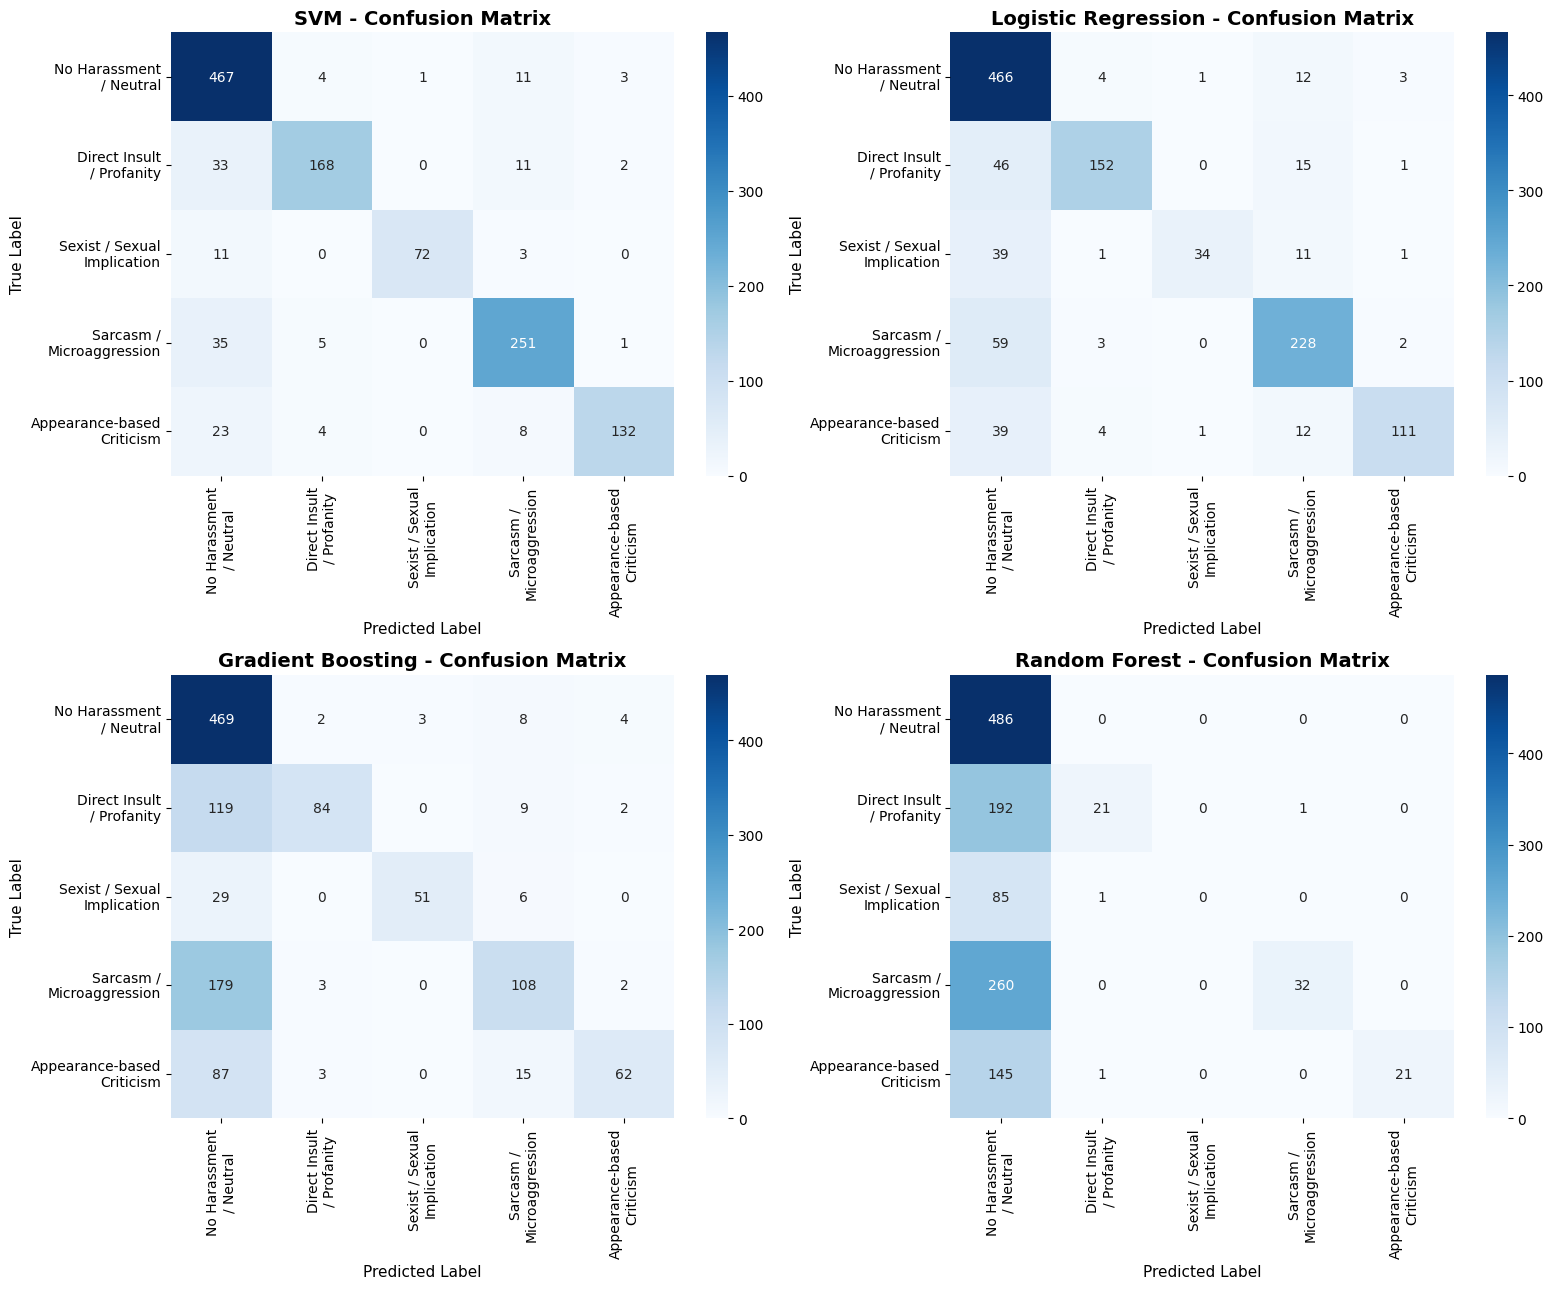

In [16]:
# Her model için confusion matrix çiz
predictions = {
    'SVM': y_pred_svm,
    'Logistic Regression': y_pred_lr,
    'Gradient Boosting': y_pred_gb,
    'Random Forest': y_pred_rf
}

fig, axes = plt.subplots(2, 2, figsize=(16, 13))
axes = axes.ravel()

# Kısa sınıf isimleri (görselleştirme için)
class_labels = [
    'No Harassment\n/ Neutral',
    'Direct Insult\n/ Profanity',
    'Sexist / Sexual\nImplication',
    'Sarcasm /\nMicroaggression',
    'Appearance-based\nCriticism'
]

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                ax=axes[idx], cbar=True)
    
    axes[idx].set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Özet ve Sonuçlar


In [17]:
print("\n" + "="*60)
print("📊 PROJE ÖZETİ")
print("="*60)
print(f"\n✅ Toplam veri sayısı: {len(df)}")
print(f"✅ Training veri sayısı: {len(y_train)}")
print(f"✅ Test veri sayısı: {len(y_test)}")
print(f"✅ Feature sayısı: {X.shape[1]}")
print(f"\n✅ Eğitilen modeller:")
print("   - Support Vector Machine (SVM)")
print("   - Logistic Regression")
print("   - Gradient Boosting")
print("   - Random Forest")
print(f"\n✅ Kaydedilen dosyalar:")
print("   - tfidf_vectorizer.pkl")
print("   - svm_model.pkl")
print("   - logistic_regression_model.pkl")
print("   - gradient_boosting_model.pkl")
print("   - random_forest_model.pkl")
print("   - model_comparison.png")
print("   - confusion_matrices.png")
print("\n" + "="*60)
print("🎉 Model eğitimi başarıyla tamamlandı!")
print("="*60)



📊 PROJE ÖZETİ

✅ Toplam veri sayısı: 6221
✅ Training veri sayısı: 4976
✅ Test veri sayısı: 1245
✅ Feature sayısı: 5000

✅ Eğitilen modeller:
   - Support Vector Machine (SVM)
   - Logistic Regression
   - Gradient Boosting
   - Random Forest

✅ Kaydedilen dosyalar:
   - tfidf_vectorizer.pkl
   - svm_model.pkl
   - logistic_regression_model.pkl
   - gradient_boosting_model.pkl
   - random_forest_model.pkl
   - model_comparison.png
   - confusion_matrices.png

🎉 Model eğitimi başarıyla tamamlandı!


## 10. Test - Örnek Tahminler


In [18]:
# Örnek metinlerle test et
test_texts = [
    "Çok güzelsin tebrikler",
    "Sen çok kötüsün git buradan",
    "Kadın olarak çok başarılısın",
    "Biraz zayıfla daha güzel olursun"
]

print("\n" + "="*60)
print("🧪 ÖRNEK TAHMİNLER")
print("="*60)

# En iyi modeli kullan (örnek olarak SVM)
best_model = svm_model

label_mapping = {
    0: "No Harassment / Neutral",
    1: "Direct Insult / Profanity",
    2: "Sexist / Sexual Implication",
    3: "Sarcasm / Microaggression",
    4: "Appearance-based Criticism"
}

for text in test_texts:
    processed = preprocess_text(text)
    vectorized = tfidf.transform([processed])
    prediction = best_model.predict(vectorized)[0]
    
    print(f"\n📝 Text: '{text}'")
    print(f"🎯 Tahmin: {label_mapping[prediction]} (Class {prediction})")

print("\n" + "="*60)



🧪 ÖRNEK TAHMİNLER

📝 Text: 'Çok güzelsin tebrikler'
🎯 Tahmin: No Harassment / Neutral (Class 0)

📝 Text: 'Sen çok kötüsün git buradan'
🎯 Tahmin: No Harassment / Neutral (Class 0)

📝 Text: 'Kadın olarak çok başarılısın'
🎯 Tahmin: No Harassment / Neutral (Class 0)

📝 Text: 'Biraz zayıfla daha güzel olursun'
🎯 Tahmin: Appearance-based Criticism (Class 4)



## 11. Test Veri Seti ile Model Karşılaştırması

In [22]:
# Test veri setini yükle
test_file_path = '/kaggle/input/turkish-cyberbullying-dataset/test_set_siber_zorbalik_v2.csv'

# Alternatif yol:
# test_file_path = '../input/test_set_siber_zorbalik_v2.csv'

print("📂 Test veri seti yükleniyor...")
print("="*60)

# CSV'yi doğru şekilde oku
df_test = pd.read_csv(test_file_path, quotechar='"', skipinitialspace=True)

print(f"📊 Orijinal test seti boyutu: {df_test.shape}")

# Label sütununu temizle
df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')

# Sadece geçerli label'ları tut (0-4)
valid_labels = [0, 1, 2, 3, 4]
df_test = df_test[df_test['label'].isin(valid_labels)]

# NaN ve boş değerleri temizle
df_test = df_test.dropna(subset=['comment', 'label'])
df_test['label'] = df_test['label'].astype(int)
df_test = df_test[df_test['comment'].str.strip() != '']
df_test = df_test.reset_index(drop=True)

print(f"✅ Temizlenmiş test seti boyutu: {df_test.shape}")
print(f"\n📈 Test seti sınıf dağılımı:")
print(df_test['label'].value_counts().sort_index())

# Test verilerini hazırla
X_test_external = df_test['comment'].apply(preprocess_text)
y_test_external = df_test['label']

# TF-IDF ile vektörize et
X_test_vectors = tfidf.transform(X_test_external)


📂 Test veri seti yükleniyor...
📊 Orijinal test seti boyutu: (50, 2)
✅ Temizlenmiş test seti boyutu: (50, 2)

📈 Test seti sınıf dağılımı:
label
0    10
1    10
2    10
3    10
4    10
Name: count, dtype: int64


### 11.1 Tüm Modellerin Test Seti Performansı


In [26]:
# Tüm modeller ile test seti üzerinde tahmin yap
print("\n" + "="*60)
print("TEST SETİ ÜZERİNDE MODEL KARŞILAŞTIRMASI")
print("="*60 + "\n")

# Tüm modelleri bir dictionary'de topla
all_models = {
    'SVM': svm_model,
    'Logistic Regression': lr_model,
    'Gradient Boosting': gb_model,
    'Random Forest': rf_model
}

# Her model için tahmin ve sonuçlar
test_results = {}

for model_name, model in all_models.items():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - TEST SETİ SONUÇLARI")
    print("="*60)
    
    # Tahmin yap
    y_pred = model.predict(X_test_vectors)
    
    # Accuracy hesapla
    accuracy = accuracy_score(y_test_external, y_pred)
    
    print(f"\n📊 Test Accuracy: {accuracy:.4f}")
    
    # Classification Report
    print(f"\n📋 Classification Report:\n")
    print(classification_report(y_test_external, y_pred, target_names=class_names))
    
    # Sonuçları kaydet
    test_results[model_name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }

print("\n" + "="*60)



TEST SETİ ÜZERİNDE MODEL KARŞILAŞTIRMASI


SVM - TEST SETİ SONUÇLARI

📊 Test Accuracy: 0.3800

📋 Classification Report:

                             precision    recall  f1-score   support

    No Harassment / Neutral       0.38      0.60      0.46        10
  Direct Insult / Profanity       0.44      0.40      0.42        10
Sexist / Sexual Implication       0.00      0.00      0.00        10
  Sarcasm / Microaggression       0.25      0.30      0.27        10
 Appearance-based Criticism       0.60      0.60      0.60        10

                   accuracy                           0.38        50
                  macro avg       0.33      0.38      0.35        50
               weighted avg       0.33      0.38      0.35        50


LOGISTIC REGRESSION - TEST SETİ SONUÇLARI

📊 Test Accuracy: 0.3400

📋 Classification Report:

                             precision    recall  f1-score   support

    No Harassment / Neutral       0.35      0.70      0.47        10
  Direct Insult / Pr

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


### 11.2 Test Seti Model Karşılaştırma Grafiği



TEST SETİ MODEL PERFORMANS SIRLAMASI
              Model  Test Accuracy
                SVM           0.38
  Gradient Boosting           0.36
Logistic Regression           0.34
      Random Forest           0.20

🏆 En iyi performans: SVM - 0.3800


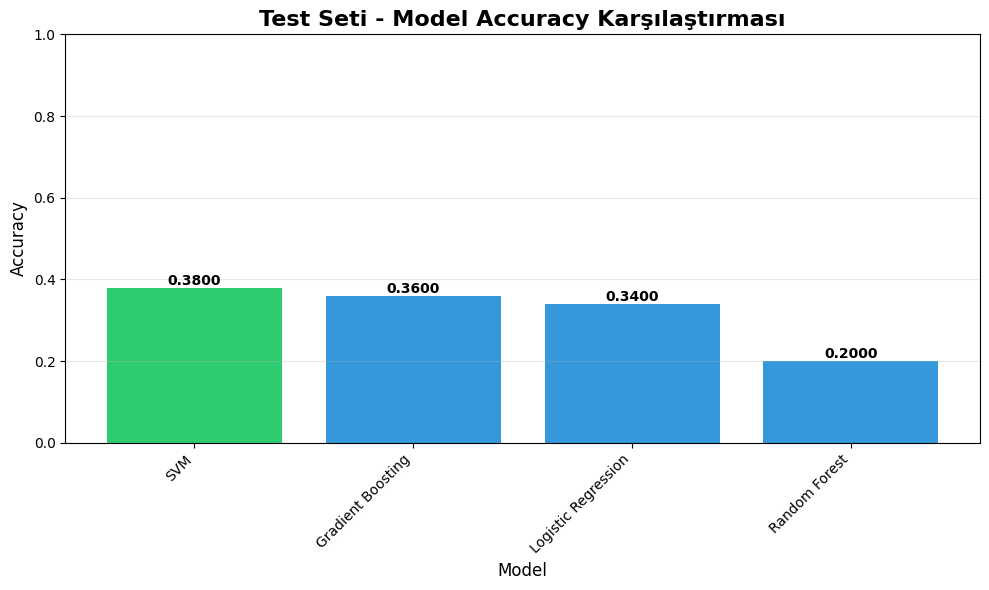

In [27]:
# Test seti sonuçlarını karşılaştır
test_accuracies = {name: result['accuracy'] for name, result in test_results.items()}
test_df = pd.DataFrame(list(test_accuracies.items()), columns=['Model', 'Test Accuracy'])
test_df = test_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print("TEST SETİ MODEL PERFORMANS SIRLAMASI")
print("="*60)
print(test_df.to_string(index=False))
print(f"\n🏆 En iyi performans: {test_df.iloc[0]['Model']} - {test_df.iloc[0]['Test Accuracy']:.4f}")

# Görselleştirme
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(test_df))]
bars = plt.bar(test_df['Model'], test_df['Test Accuracy'], color=colors)

plt.title('Test Seti - Model Accuracy Karşılaştırması', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Bar'ların üzerine değerleri yaz
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('test_set_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### 11.3 Test Seti Confusion Matrices


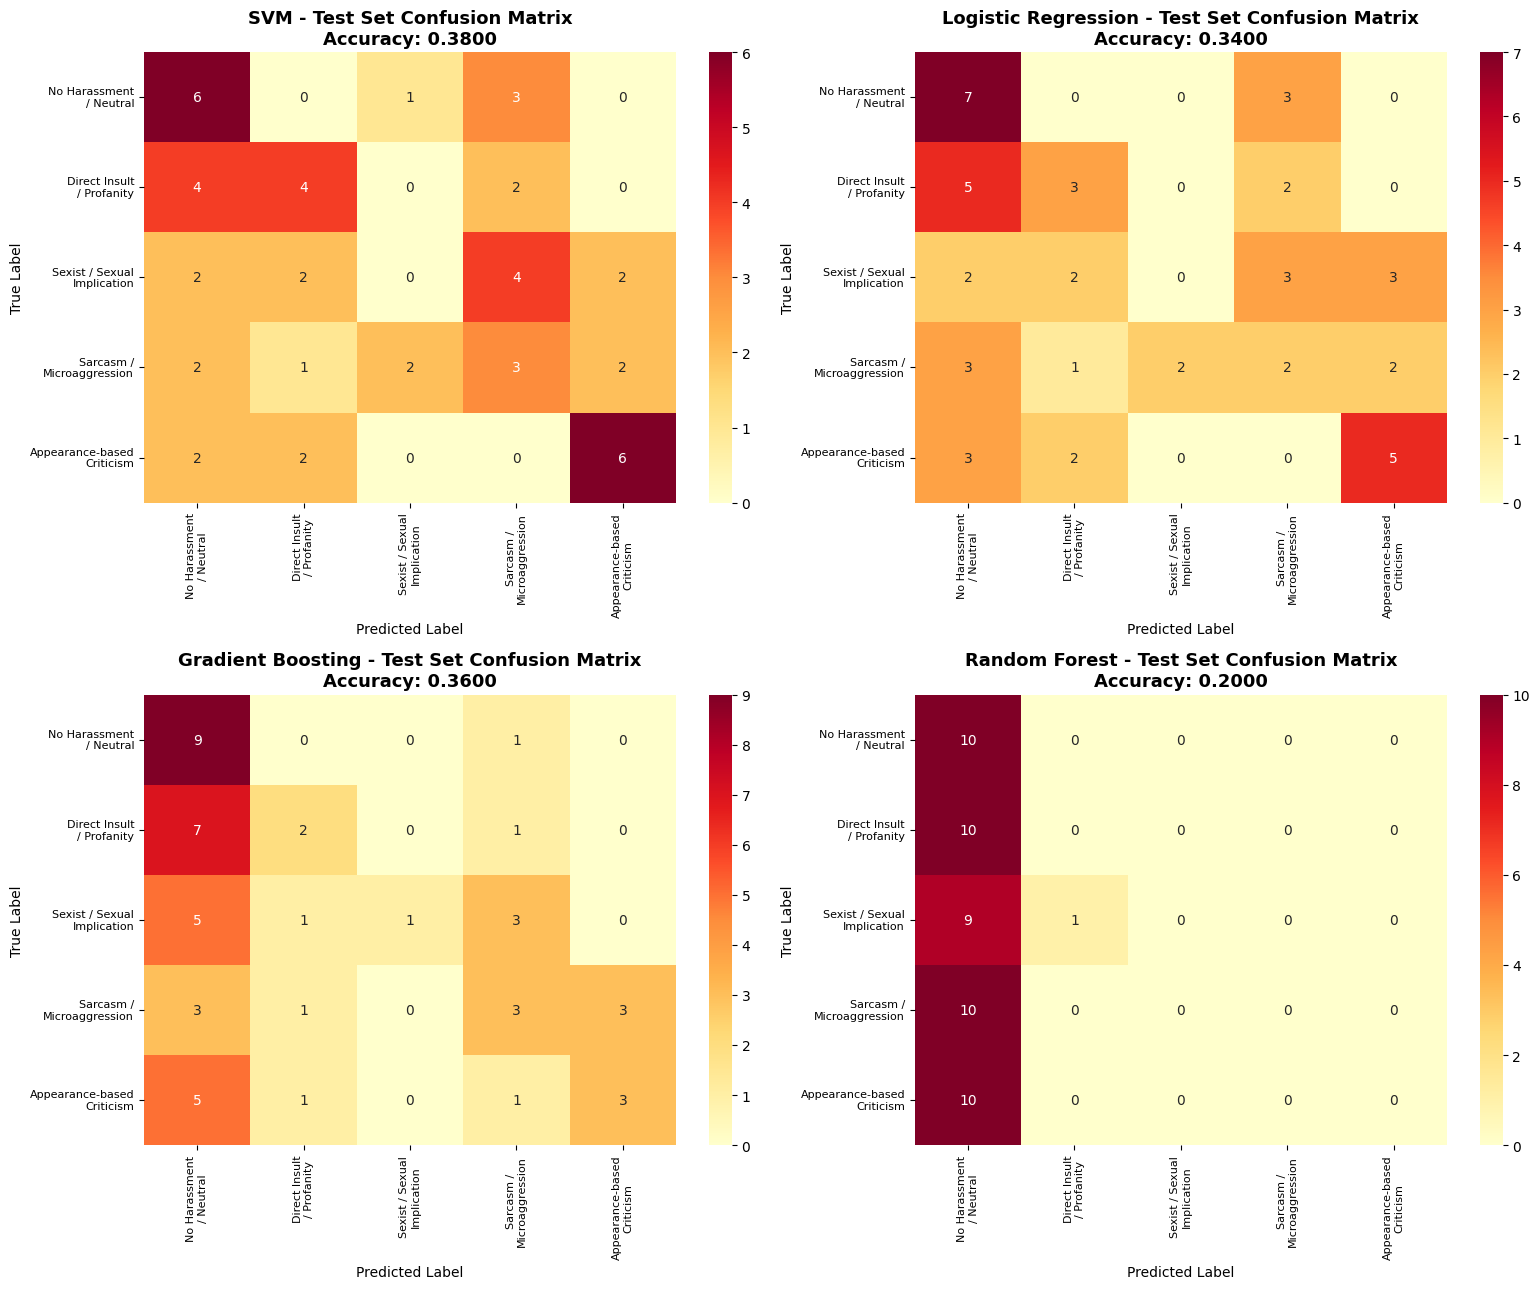


✅ Test seti değerlendirmesi tamamlandı!
📊 Grafik kaydedildi: test_set_model_comparison.png
📊 Confusion matrices kaydedildi: test_set_confusion_matrices.png


In [28]:
# Test seti için confusion matrix görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 13))
axes = axes.ravel()

# Kısa sınıf isimleri
class_labels_short = [
    'No Harassment\n/ Neutral',
    'Direct Insult\n/ Profanity',
    'Sexist / Sexual\nImplication',
    'Sarcasm /\nMicroaggression',
    'Appearance-based\nCriticism'
]

for idx, (model_name, result) in enumerate(test_results.items()):
    cm = confusion_matrix(y_test_external, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=class_labels_short, yticklabels=class_labels_short,
                ax=axes[idx], cbar=True)
    
    axes[idx].set_title(f'{model_name} - Test Set Confusion Matrix\nAccuracy: {result["accuracy"]:.4f}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('test_set_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Test seti değerlendirmesi tamamlandı!")
print("📊 Grafik kaydedildi: test_set_model_comparison.png")
print("📊 Confusion matrices kaydedildi: test_set_confusion_matrices.png")


================================================================================
DEĞERLENDIRME SONUÇLARI GEMINI 2.0 Flash Global test seti.
================================================================================

📊 Genel Doğruluk (Accuracy): 0.8444 (84.44%)
📊 Ortalama Güven Skoru: 0.5587

================================================================================
CLASSIFICATION REPORT
================================================================================
                                precision    recall  f1-score   support

    0: No Harassment / Neutral     1.0000    1.0000    1.0000        10
  1: Direct Insult / Profanity     1.0000    0.8000    0.8889        10
2: Sexist / Sexual Implication     0.5000    1.0000    0.6667         5
  3: Sarcasm / Microaggression     0.8333    0.6250    0.7143         8
 4: Appearance-based Criticism     0.9091    0.8333    0.8696        12

                      accuracy                         0.8444        45
                     macro avg     0.8485    0.8517    0.8279        45
                  weighted avg     0.8906    0.8444    0.8527        45


================================================================================
CONFUSION MATRIX
================================================================================

    Pred- 0 Pred- 1 Pred- 2 Pred- 3 Pred- 4
    --------------------------------------------------
True-0 |     10      0      0      0      0
True-1 |      0      8      0      1      1
True-2 |      0      0      5      0      0
True-3 |      0      0      3      5      0
True-4 |      0      0      2      0     10

================================================================================
KATEGORİ BAZINDA DETAYLI ANALİZ
================================================================================

📌 Kategori 0: No Harassment / Neutral
   - Gerçek örnekler: 10
   - Tahmin edilen: 10
   - Doğru tahmin: 10
   - Kategori doğruluğu: 1.0000 (100.00%)

📌 Kategori 1: Direct Insult / Profanity
   - Gerçek örnekler: 10
   - Tahmin edilen: 8
   - Doğru tahmin: 8
   - Kategori doğruluğu: 0.8000 (80.00%)

📌 Kategori 2: Sexist / Sexual Implication
   - Gerçek örnekler: 5
   - Tahmin edilen: 10
   - Doğru tahmin: 5
   - Kategori doğruluğu: 1.0000 (100.00%)

📌 Kategori 3: Sarcasm / Microaggression
   - Gerçek örnekler: 8
   - Tahmin edilen: 6
   - Doğru tahmin: 5
   - Kategori doğruluğu: 0.6250 (62.50%)

📌 Kategori 4: Appearance-based Criticism
   - Gerçek örnekler: 12
   - Tahmin edilen: 11
   - Doğru tahmin: 10
   - Kategori doğruluğu: 0.8333 (83.33%)